In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## Downscaling for TRMM 3h in CONUS region

In [2]:
yy_s = 2008
yy_e = 2012

maxmiss = 80

## Haversine distance

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [4]:
base_dir = os.path.join('/','home','arturo','github','downpy','data')

## LOAD TRMM TMPA DATA

In [5]:
data_dir = os.path.join(base_dir, 'tmpa_conus_data', 'data_tmpa_3h_2008_2012.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

time_vector = DATA['time'].data

dset = np.array(DATA['PRE'].data)
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 4GB
Dimensions:  (lon: 280, lat: 112, time: 14615)
Coordinates:
  * time     (time) datetime64[ns] 117kB 2008-01-01T03:00:00 ... 2012-12-31T2...
  * lat      (lat) float64 896B 22.12 22.38 22.62 22.88 ... 49.38 49.62 49.88
  * lon      (lon) float64 2kB -129.9 -129.6 -129.4 ... -60.62 -60.38 -60.12
Data variables:
    PRE      (lon, lat, time) float64 4GB 0.0 0.0 0.0 nan ... 0.0 0.0 0.0 0.0
Attributes:
    description:  TRMM TMPA 3 hour 2008 data for CONUS region

## Load Raingauges

In [6]:
file_list = glob.glob(os.path.join(base_dir, 'data_noaa_hpd_gauges', 'daily_csv', '*.csv'))
file_list = sorted(file_list)
len_list = len(file_list)
print(f'NUmber of files: {len_list}')

list_names = []
for nn in range(len_list):
    tmp = file_list[nn].split('/')[-1].split('.')[0]
    list_names.append(tmp)

data_dir = os.path.join(base_dir, 'data_noaa_hpd_gauges', 'HOURLY_LOC_NYEARS.csv')
INFO = pd.read_csv(data_dir)

NUmber of files: 1928


In [7]:
lo_limit_min, lo_limit_max, la_limit_min, la_limit_max = -90, -80, 30, 35

In [8]:
lat_rain = []
lon_rain = []
id_rain = []
for nn in range(len(list_names)):
    TEST = INFO[INFO['ID']==list_names[nn]]
    lat_rain.append(TEST['LAT'].values[0])
    lon_rain.append(TEST['LON'].values[0])
    id_rain.append(TEST['ID'].values[0])

lat_rain = np.array(lat_rain)
lon_rain = np.array(lon_rain)
id_rain = np.array(id_rain)

lat_bnds = np.where((lat_rain>=la_limit_min)&(lat_rain<=la_limit_max))[0]

lat_rain = lat_rain[lat_bnds]
lon_rain = lon_rain[lat_bnds]
id_rain = id_rain[lat_bnds]

lon_bnds = np.where((lon_rain>=lo_limit_min)&(lon_rain<=lo_limit_max))[0]

lat_rain = lat_rain[lon_bnds]
lon_rain = lon_rain[lon_bnds]
id_rain = id_rain[lon_bnds]

## Choose station

In [9]:
pos_ref = 40
pos_ref = 22

RAIN_lat = lat_rain[pos_ref]
RAIN_lon = lon_rain[pos_ref]
cid = id_rain[pos_ref]

## Load Data

In [10]:
input_dir = os.path.join(base_dir,'data_noaa_hpd_gauges','daily_csv',f'{cid}.csv')
RAIN = pd.read_csv(input_dir)

print(f'Original OBS S_time: {RAIN['DATE'].values[0]}')
print(f'Original OBS E_time: {RAIN['DATE'].values[len(RAIN)-1]}')

RAIN = RAIN[(RAIN['YEAR']>=yy_s)&(RAIN['YEAR']<=yy_e)]

RAIN=RAIN.mask(RAIN==np.min(RAIN['PRCP'])).fillna(0)

datetime_OBS = pd.to_datetime(RAIN['DATE'].values, format='%Y%m%d')
RAIN['TIME'] = datetime_OBS

print()
print(f'New OBS S_time     : {RAIN['TIME'].values[0]}')
print(f'New OBS E_time     : {RAIN['TIME'].values[len(RAIN)-1]}')

Original OBS S_time: 19980331
Original OBS E_time: 20170702

New OBS S_time     : 2008-01-01T00:00:00.000000000
New OBS E_time     : 2012-12-31T00:00:00.000000000


## Identify TRMM pixel

In [11]:
distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

IMERG_ML = dset[min_index[1],min_index[0],:]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 32.375
Station lat       : 32.26

Nearest IMERG lon: -86.125
Station lon       : -86.218


## Convert TRMM serie to xarray and Weibull parameters

In [12]:
IMERG_ML_xr = xr.DataArray(IMERG_ML,  coords={'time':time_vector}, dims=('time'))
IMERG_ML_xr = IMERG_ML_xr.resample(time ='D').sum(dim='time', skipna=False)
NCW_IMERG, YEARS_IMERG = down.fit_yearly_weibull(IMERG_ML_xr, thresh=1, maxmiss=maxmiss)

## Create a manual time vector

In [13]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

## Verify the OBS and TRMM times

In [14]:
if len(RAIN['PRCP'].values) < len(TIME_REF):
    print('OBS time is not complete. Verify data')
    OBS_NEW = pd.merge(RAIN, TIME_PD, on='TIME', how='right')

if len(IMERG_ML_xr) <  len(TIME_REF):
    print('Warning! TRMM time is not complete. Verify data')

OBS time is not complete. Verify data


In [15]:
OBS_xr = xr.DataArray(OBS_NEW['PRCP'].values,  coords={'time':OBS_NEW['TIME'].values}, dims=('time'))
NCW_OBS, YEARS_OBS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)

In [16]:
len(IMERG_ML_xr.data),len(OBS_xr.data), len(OBS_NEW)

(1827, 1827, 1827)

In [17]:
bnds1 = np.where(~np.isnan(IMERG_ML_xr.data))[0]
IMERG_clear = IMERG_ML_xr.data[bnds1]
OBS_clear = OBS_xr.data[bnds1]

bnds2 = np.where(~np.isnan(OBS_clear))[0]
IMERG_clear = IMERG_clear[bnds2]
OBS_clear = OBS_clear[bnds2]

corr, _ = stats.spearmanr(IMERG_clear, OBS_clear)
corr = np.round(corr,2)

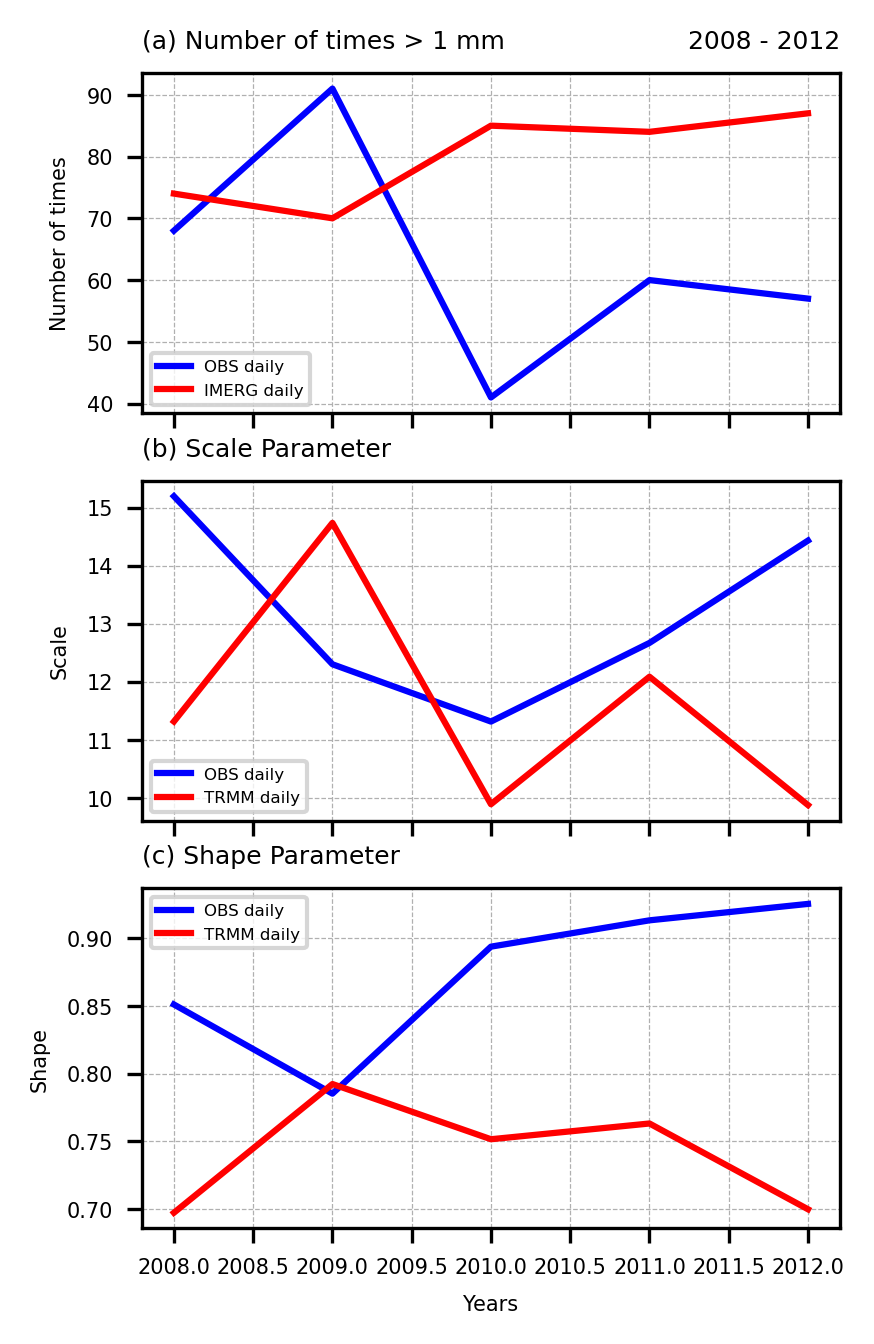

In [18]:
fig = plt.figure(figsize=(3,5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,0], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_ylabel('Number of times', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,1], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,2], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,2], c='r', label=f'TRMM daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

Text(1.0, 1.0, 'Correlation: 0.53')

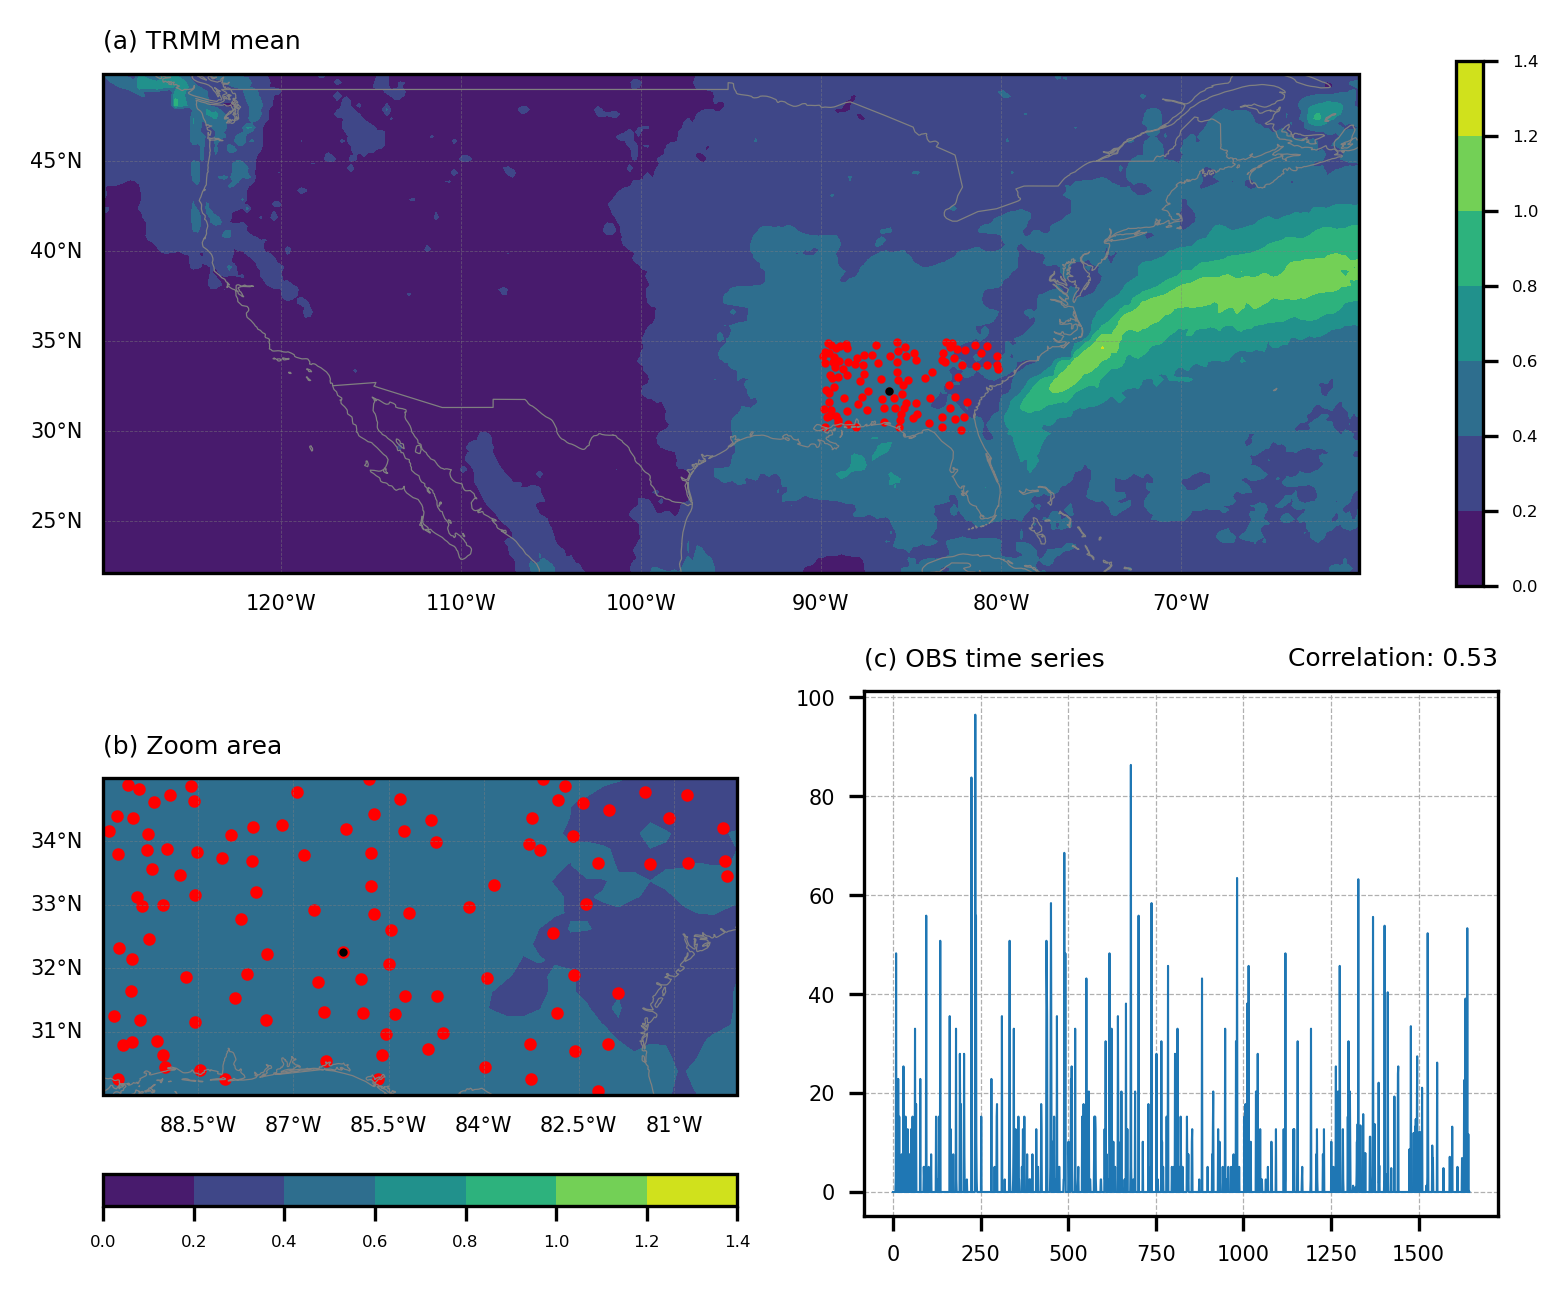

In [19]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,5),dpi=300)
gs = gridspec.GridSpec(2,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0:], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(dset,axis=2).T)
ax1.scatter(lon_rain,lat_rain, s=1, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.07, fraction=0.03)
cbar.ax.tick_params(labelsize=4) 

ax1.set_title(f'(a) TRMM mean', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([lo_limit_min, lo_limit_max, la_limit_min, la_limit_max], crs=proj)

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(dset,axis=2).T)
ax1.scatter(lon_rain,lat_rain, s=4, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='horizontal', pad=0.15, fraction=0.08)
cbar.ax.tick_params(labelsize=4) 

ax1.set_title(f'(b) Zoom area', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.plot(RAIN['PRCP'].values, linewidth=0.5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_title(f'(c) OBS time series', fontsize=6, loc='left')
ax1.set_title(f'Correlation: {corr}', fontsize=6, loc='right')

In [20]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

npix = 3
buffer = 0.5*npix*dx
print(f'Buffer size: {buffer}')

Buffer size: 0.375


In [21]:
xrs0 = xr.DataArray(dset,  coords={'lon':lons, 'lat':lats, 'time':time_vector}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [22]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [23]:
box_3h = xrs.where(bcond, drop = True).load()
box_daily = box_3h.resample(time ='D').sum(dim='time', skipna=False)
box_daily.shape

(3, 3, 1827)

In [24]:
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=maxmiss, clat=clat, clon=clon,
                            opt_method='genetic', plot=True) #maxmiss=36

Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.002328767740696394
differential_evolution step 2: f(x)= 0.0022551367516901438
differential_evolution step 3: f(x)= 0.0022551367516901438
differential_evolution step 4: f(x)= 0.00150617114840345
differential_evolution step 5: f(x)= 0.0014778937938314664
differential_evolution step 6: f(x)= 0.0006008244242887396
differential_evolution step 7: f(x)= 0.0006008244242887396
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [25]:
downres['beta']

0.9803138821742077

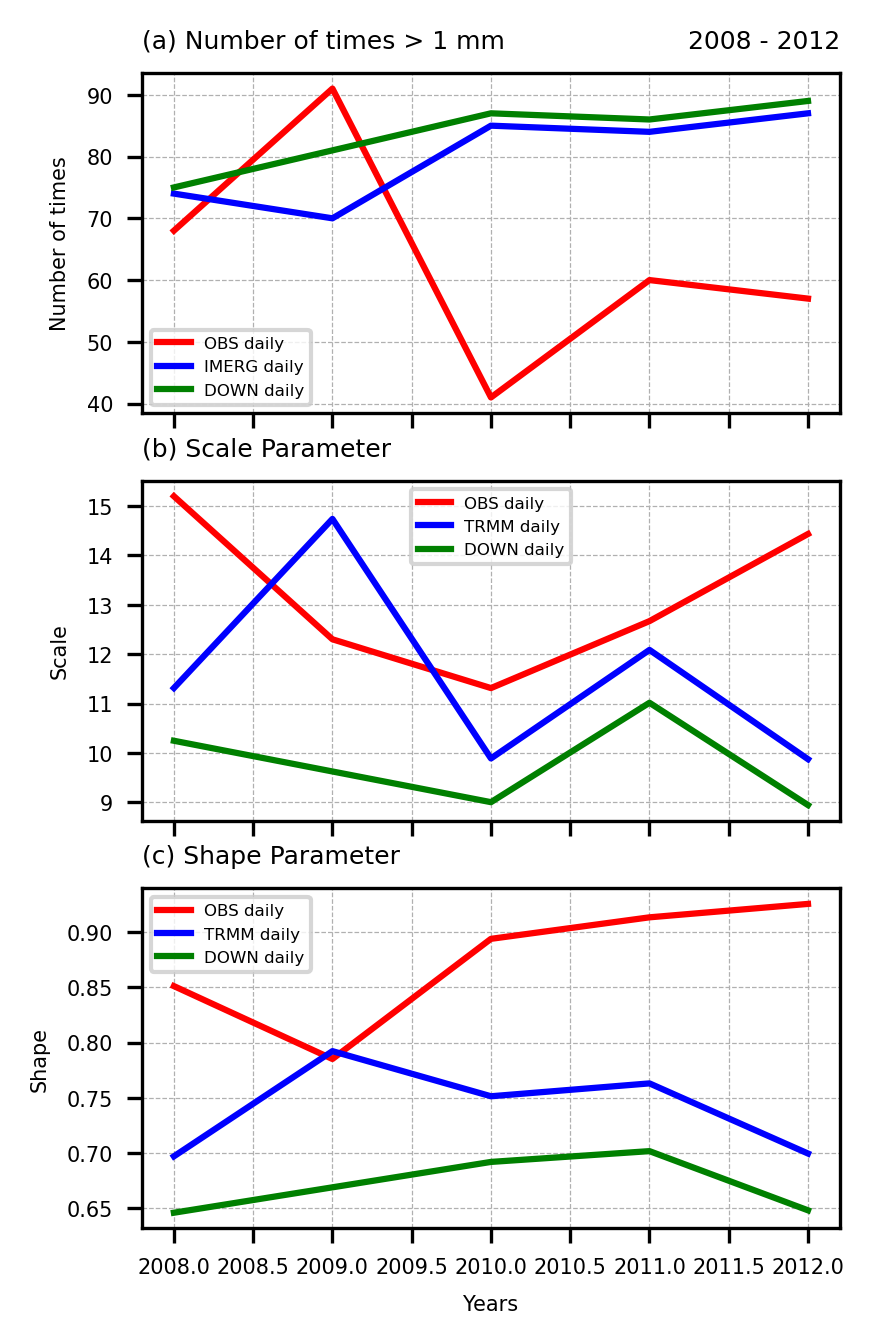

In [26]:
fig = plt.figure(figsize=(3,5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,0], c='r', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], c='b', label=f'IMERG daily')
ax1.plot(downres['YEARS'], downres['NYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_ylabel('Number of times', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,1], c='r', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], c='b', label=f'TRMM daily')
ax1.plot(downres['YEARS'], downres['CYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,2], c='r', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,2], c='b', label=f'TRMM daily')
ax1.plot(downres['YEARS'], downres['WYd'], c='g', label=f'DOWN daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)